In [1]:
import numpy as np
from scipy import interpolate
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from analyse_contacts_utils import read_expe1, read_expe2, read_expe3, ground_truth, compute_tptnfpfn, plot_tptnfpfn
import sklearn
%matplotlib notebook

# read datasets

In [2]:
t_arr1, mocapd1, measd1 = read_expe1()
t_arr2, mocapd2, measd2 = read_expe2()
t_arr3, mocapd3, measd3 = read_expe3()
N1 = len(t_arr1)
N2 = len(t_arr2)
N3 = len(t_arr3)

In [3]:
# features in 

# create ground truth

In [4]:
# to get ground truth :
# - foot height
# - foot velocity

# to obtain:  
# height with respect to previous lowest height

In [5]:
y1 = ground_truth(mocapd1['FL'][:,2])
y2 = ground_truth(mocapd2['FL'][:,2])
y3 = ground_truth(mocapd3['FL'][:,2])

<IPython.core.display.Javascript object>


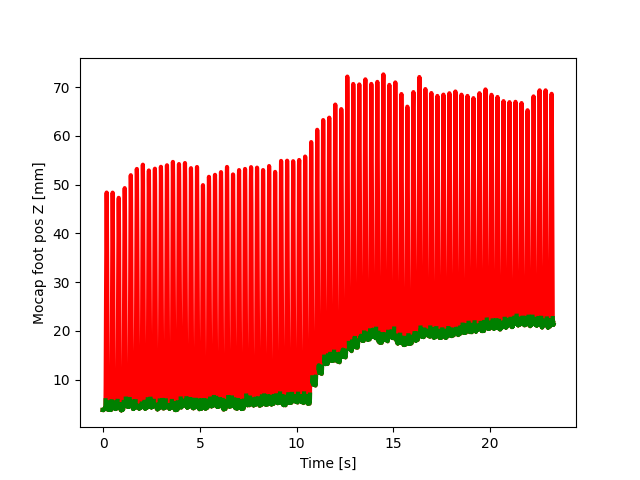

Text(0, 0.5, 'Mocap foot pos Z [mm]')

In [6]:
plt.figure('ground truth 3')
plt.plot(t_arr3, mocapd3['FL'][:,2], "r", label='nope', linewidth=3)
tmp = mocapd3['FL'][:,2].copy()
tmp[np.logical_not(y3.astype(bool))] = np.nan
plt.plot(t_arr3, tmp, "g", label='contact', linewidth=3)
plt.xlabel("Time [s]")
plt.ylabel("Mocap foot pos Z [mm]")

# KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
# data
X1 = np.zeros((len(t_arr1), 3))
X1[:, 0:3] = measd1['tau'][:, 0:3]  # FL .. .. ..

X2 = np.zeros((len(t_arr1), 3))
X2[:, 0:3] = measd1['tau'][:, 0:3]  # FL .. .. ..

In [9]:
clf = KNeighborsClassifier(n_neighbors=2)

In [10]:
clf.fit(X1, y1)

KNeighborsClassifier(n_neighbors=2)

In [11]:
clf.predict(X2)

array([ True,  True,  True, ...,  True,  True, False])

# SVC

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
C = 0.01 # SVM regularization parameter
n_components = 2
estimators = [('scaler', sklearn.preprocessing.StandardScaler()),
              ('reduce_dim', sklearn.decomposition.IncrementalPCA(n_components=n_components, batch_size=100)),
              ('clf', sklearn.svm.SVC(kernel='rbf', C=C))]
pca_svc_clf = sklearn.pipeline.Pipeline(estimators)

estimators = [('scaler', sklearn.preprocessing.StandardScaler()),
              ('clf', sklearn.svm.SVC(kernel='rbf', C=C))]
svc_clf = sklearn.pipeline.Pipeline(estimators)

In [14]:
X1 = np.zeros((len(t_arr1), 6))
X1[:, 0:3] = measd1['tau'][:, 0:3]  # FL .. .. ..
X1[:, 0:3] = measd1['qa'][:, 0:3]  # FL .. .. ..

X2 = np.zeros((len(t_arr2), 6))
X2[:, 0:3] = measd1['tau'][:, 0:3]  # FL .. .. ..
X2[:, 0:3] = measd1['qa'][:, 0:3]  # FL .. .. ..

X3 = np.zeros((len(t_arr3), 6))
X3[:, 0:3] = measd1['tau'][:, 0:3]  # FL .. .. ..
X3[:, 0:3] = measd1['qa'][:, 0:3]  # FL .. .. ..



In [15]:
scores_pca_svc = cross_val_score(pca_svc_clf, X1, y1, cv=5)
scores_svc = cross_val_score(svc_clf, X1, y1, cv=5)

In [16]:
print(scores_pca_svc.mean(), scores_pca_svc.std())
print(scores_svc.mean(), scores_svc.std())

0.97075 0.0032956199888808887
0.9722500000000001 0.0025900450446533505


In [17]:
print(scores_pca_svc.mean(), scores_pca_svc.std())
print(scores_svc.mean(), scores_svc.std())

0.97075 0.0032956199888808887
0.9722500000000001 0.0025900450446533505


In [18]:
pca_svc_clf.fit(X1, y1)
svc_clf.fit(X1, y1)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(C=0.01))])

In [19]:
# Test sets
y2_pred_pca_svc = pca_svc_clf.predict(X2)
y3_pred_pca_svc = pca_svc_clf.predict(X3)

y2_pred_svc = svc_clf.predict(X2)
y3_pred_svc = svc_clf.predict(X3)

In [20]:
print(sklearn.metrics.f1_score(y2_pred_pca_svc, y2))
print(sklearn.metrics.f1_score(y2_pred_svc, y2))
print(sklearn.metrics.f1_score(y3_pred_pca_svc, y3))
print(sklearn.metrics.f1_score(y3_pred_svc, y3))

0.9651162790697675
0.9649609943144255
0.9580132450331125
0.9573227302849568


In [21]:
print(sklearn.metrics.confusion_matrix(y2_pred_pca_svc, y2)*100/N2)
print(sklearn.metrics.confusion_matrix(y3_pred_pca_svc, y3)*100/N3)
print(sklearn.metrics.confusion_matrix(y2_pred_svc, y2)*100/N2)
print(sklearn.metrics.confusion_matrix(y3_pred_svc, y3)*100/N3)

[[34.73333333  0.50833333]
 [ 3.89166667 60.86666667]]
[[34.44166667  0.8       ]
 [ 4.48333333 60.275     ]]
[[34.76666667  0.55833333]
 [ 3.85833333 60.81666667]]
[[34.44166667  0.88333333]
 [ 4.48333333 60.19166667]]


## plot true positive etc.

<IPython.core.display.Javascript object>


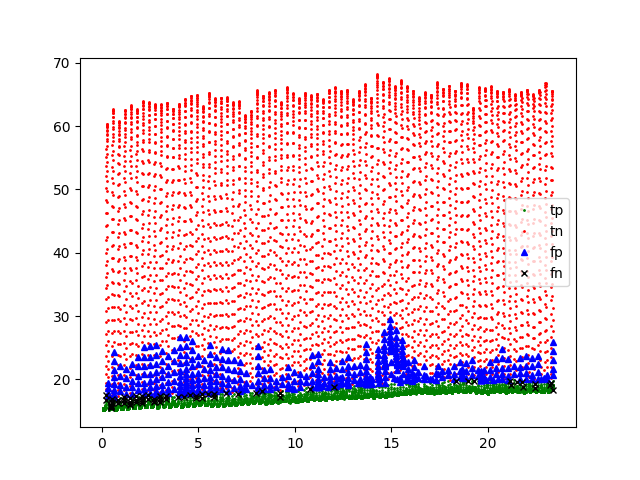

In [22]:
ytp ,ytn ,yfp ,yfn = compute_tptnfpfn(y2_pred_svc, y2)
z_arr = mocapd2['FL'][:,2]
plot_tptnfpfn(t_arr2, z_arr, ytp ,ytn ,yfp ,yfn)

<IPython.core.display.Javascript object>


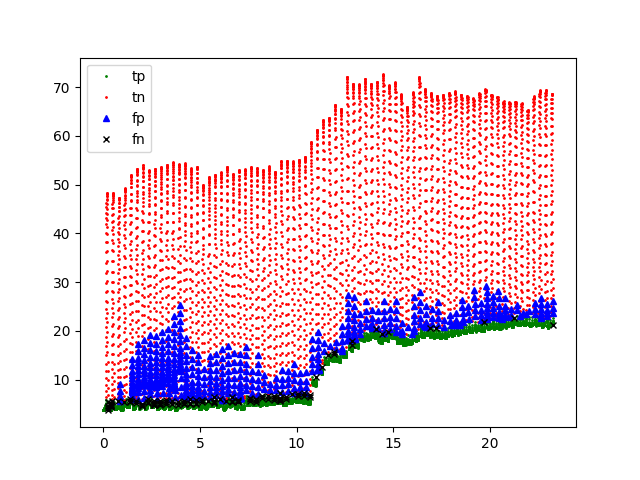

In [23]:
ytp ,ytn ,yfp ,yfn = compute_tptnfpfn(y3_pred_svc, y3)
z_arr = mocapd3['FL'][:,2]
plot_tptnfpfn(t_arr3, z_arr, ytp ,ytn ,yfp ,yfn)